In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import warnings
import sys
from pathlib import Path
import glob
from collections import Counter, defaultdict
import networkx as nx
from sklearn.feature_extraction.text import TfidfVectorizer
from wordcloud import WordCloud
import re
from pathlib import Path

# Configuration
warnings.filterwarnings('ignore')
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

# Add src to path
sys.path.append('../src')
from config import config

In [4]:
try:
    listings_df = pd.read_csv(config.listings_path)
    print(f"Listings loaded: {len(listings_df):,} rows")
except FileNotFoundError:
    print("listing.csv not found. Please ensure dataset is in data/ folder")
    listings_df = None

try:
    duplicates_df = pd.read_csv(config.duplicates_path)
    print(f"Duplicates loaded: {len(duplicates_df):,} pairs")
except FileNotFoundError:
    print("duplicate_listing.csv not found. Please ensure dataset is in data/ folder")
    duplicates_df = None

# Check for pictures directory
pictures_path = config.pictures_path
if pictures_path.exists():
    image_files = list(pictures_path.glob("*.*"))
    print(f"Pictures directory found: {len(image_files):,} images")
else:
    print("Pictures directory not found")
    image_files = []

Listings loaded: 1,428 rows
Duplicates loaded: 3,584 pairs
Pictures directory found: 13,248 images


In [8]:
# Dataset Structure Analysis

print(" Listings Dataset Info:")
print(f"   Shape: {listings_df.shape}")
print(f"   Memory usage: {listings_df.memory_usage(deep=True).sum() / 1024**2:.1f} MB")

print("\n Column Information:")
for col in listings_df.columns:
    dtype = listings_df[col].dtype
    null_count = listings_df[col].isnull().sum()
    null_pct = (null_count / len(listings_df)) * 100
    unique_count = listings_df[col].nunique()
    
    print(f"   {col:20} | {str(dtype):15} | {null_count:6} nulls ({null_pct:5.1f}%) | {unique_count:6} unique")

# Display first few rows
print("\n🔍 Sample Data:")
display(listings_df.head())

# Basic statistics for numerical columns
print("\n Numerical Columns Statistics:")
numerical_cols = ["surface_m2", "room_count", "floor", "floor_count", "current_price"]
display(listings_df[numerical_cols].describe())

 Listings Dataset Info:
   Shape: (1428, 11)
   Memory usage: 1.7 MB

 Column Information:
   listing_id           | int64           |      0 nulls (  0.0%) |   1428 unique
   surface_m2           | int64           |      0 nulls (  0.0%) |     90 unique
   description          | object          |      0 nulls (  0.0%) |    881 unique
   room_count           | float64         |      3 nulls (  0.2%) |      7 unique
   floor                | float64         |    151 nulls ( 10.6%) |     10 unique
   floor_count          | float64         |    474 nulls ( 33.2%) |      9 unique
   current_price        | int64           |      0 nulls (  0.0%) |    265 unique
   city                 | object          |      0 nulls (  0.0%) |      1 unique
   city_zip             | int64           |      0 nulls (  0.0%) |      1 unique
   transaction_type     | object          |      0 nulls (  0.0%) |      1 unique
   item_type            | object          |      0 nulls (  0.0%) |      1 unique

🔍 Samp

,listing_id,surface_m2,description,room_count,floor,floor_count,current_price,city,city_zip,transaction_type,item_type
0,121205222,57,*** CONFLANS SAINTE HONORINE - proche COMMERCE...,4.0,3.0,NaN,195000,Conflans-Sainte-Honorine,78700,sell,apartment
1,110085329,48,** AGENCE WEELODGE ** Dans le secteur de FIN D...,2.0,NaN,NaN,157500,Conflans-Sainte-Honorine,78700,sell,apartment
2,122402493,53,*** CONFLANS SAINTE HONORINE - IDEAL 1ER ACHAT...,3.0,2.0,NaN,142000,Conflans-Sainte-Honorine,78700,sell,apartment
3,117274348,67,** AGENCE WEELODGE ** PROCHE GARE SNCF et CENT...,4.0,4.0,NaN,185000,Conflans-Sainte-Honorine,78700,sell,apartment
4,123155187,75,** AGENCE WEELODGE CONFLANS ** A 10MIN DE LA G...,4.0,3.0,4.0,189900,Conflans-Sainte-Honorine,78700,sell,apartment



 Numerical Columns Statistics:


,surface_m2,room_count,floor,floor_count,current_price
count,1428.000000,1425.000000,1277.000000,954.000000,1428.000000
mean,62.317927,3.282105,1.960063,3.045073,198141.036415
std,17.651291,0.960086,1.372297,1.763886,52622.699369
min,0.000000,1.000000,-1.000000,0.000000,0.000000
25%,53.000000,3.000000,1.000000,2.000000,167500.000000
50%,63.000000,3.000000,2.000000,3.000000,188000.000000
75%,70.000000,4.000000,3.000000,4.000000,229000.000000
max,179.000000,7.000000,8.000000,9.000000,485000.000000


In [9]:
# Duplicate Pairs Analysis
print("Duplicate Dataset Info:")
print(f"   Shape: {duplicates_df.shape}")
print(f"   Unique listings in duplicates: {len(set(duplicates_df['listing_id_1'].tolist() + duplicates_df['listing_id_2'].tolist())):,}")

# Show sample duplicate pairs
print("\n🔍 Sample Duplicate Pairs:")
display(duplicates_df.head())

# Check for bidirectional pairs
duplicates_set = set()
bidirectional_count = 0

for _, row in duplicates_df.iterrows():
    pair1 = tuple(sorted([row['listing_id_1'], row['listing_id_2']]))
    if pair1 in duplicates_set:
        bidirectional_count += 1
    duplicates_set.add(pair1)

print(f"\n Duplicate Pairs Statistics:")
print(f"   Total pairs: {len(duplicates_df):,}")
print(f"   Unique pairs: {len(duplicates_set):,}")
print(f"   Bidirectional duplicates: {bidirectional_count}")


Duplicate Dataset Info:
   Shape: (3584, 2)
   Unique listings in duplicates: 1,232

🔍 Sample Duplicate Pairs:


,listing_id_1,listing_id_2
0,64721495,64728971
1,64721495,65459581
2,64728971,65459581
3,98430083,98429480
4,119279327,116630374



 Duplicate Pairs Statistics:
   Total pairs: 3,584
   Unique pairs: 3,555
   Bidirectional duplicates: 29


In [11]:
# Connected Components Analysis (Duplicate Clusters)
if duplicates_df is not None:
    print("\n DUPLICATE CLUSTERS ANALYSIS")
    print("-" * 30)
    
    # Create graph to find connected components
    G = nx.Graph()
    
    # Add edges from duplicate pairs
    for _, row in duplicates_df.iterrows():
        G.add_edge(row['listing_id_1'], row['listing_id_2'])
    
    # Find connected components (duplicate clusters)
    connected_components = list(nx.connected_components(G))
    
    print(f"Cluster Statistics:")
    print(f"   Number of duplicate clusters: {len(connected_components):,}")
    print(f"   Total listings in clusters: {sum(len(comp) for comp in connected_components):,}")
    
    # Analyze cluster sizes
    cluster_sizes = [len(comp) for comp in connected_components]
    cluster_size_counts = Counter(cluster_sizes)
    
    print(f"\n Cluster Size Distribution:")
    for size in sorted(cluster_size_counts.keys()):
        count = cluster_size_counts[size]
        print(f"   Clusters with {size} listings: {count:,} clusters ({count * size:,} total listings)")



 DUPLICATE CLUSTERS ANALYSIS
------------------------------
Cluster Statistics:
   Number of duplicate clusters: 279
   Total listings in clusters: 1,232

 Cluster Size Distribution:
   Clusters with 1 listings: 2 clusters (2 total listings)
   Clusters with 2 listings: 98 clusters (196 total listings)
   Clusters with 3 listings: 53 clusters (159 total listings)
   Clusters with 4 listings: 33 clusters (132 total listings)
   Clusters with 5 listings: 16 clusters (80 total listings)
   Clusters with 6 listings: 27 clusters (162 total listings)
   Clusters with 7 listings: 12 clusters (84 total listings)
   Clusters with 8 listings: 11 clusters (88 total listings)
   Clusters with 9 listings: 6 clusters (54 total listings)
   Clusters with 10 listings: 6 clusters (60 total listings)
   Clusters with 11 listings: 4 clusters (44 total listings)
   Clusters with 12 listings: 3 clusters (36 total listings)
   Clusters with 13 listings: 3 clusters (39 total listings)
   Clusters with 14 li

In [12]:
# Show largest clusters
largest_clusters = sorted(connected_components, key=len, reverse=True)[:5]
print(f"\n Top 5 Largest Clusters:")
for i, cluster in enumerate(largest_clusters, 1):
    print(f"   {i}. Cluster size {len(cluster)}: {list(cluster)[:10]}{'...' if len(cluster) > 10 else ''}")


 Top 5 Largest Clusters:
   1. Cluster size 24: [120336259, 119727878, 119044112, 122686363, 122617763, 119438511, 121050034, 120094262, 120979137, 122531010]...
   2. Cluster size 22: [113983745, 116517382, 113380106, 114160140, 115458063, 116420884, 116338325, 115234728, 114563510, 114508472]...
   3. Cluster size 18: [65456256, 67292448, 64025570, 75328835, 75304965, 71125158, 68728685, 64722576, 64724721, 64722229]...
   4. Cluster size 18: [116923616, 121882529, 122068676, 121127428, 117573605, 116238116, 117249768, 113753513, 113380488, 121050027]...
   5. Cluster size 14: [122348801, 117949695, 121379238, 116382342, 117494600, 113817991, 115571047, 114823692, 113369936, 119253234]...


Missing Values Summary:


,Column,Missing_Count,Missing_Percent
5,floor_count,474,33.193277
4,floor,151,10.574230
3,room_count,3,0.210084


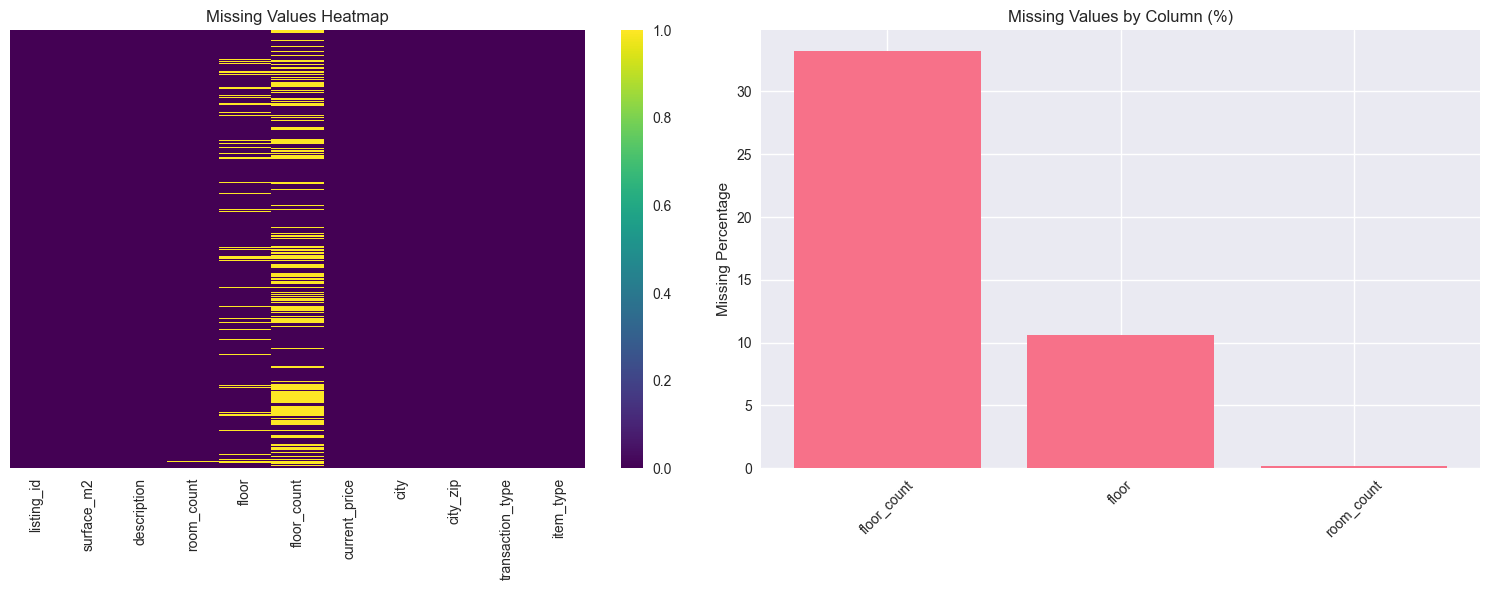

In [13]:
# Missing Values Analysis
missing_data = listings_df.isnull().sum()
missing_percent = (missing_data / len(listings_df)) * 100

missing_df = pd.DataFrame({
    'Column': missing_data.index,
    'Missing_Count': missing_data.values,
    'Missing_Percent': missing_percent.values
}).sort_values('Missing_Percent', ascending=False)

print("Missing Values Summary:")
display(missing_df[missing_df['Missing_Count'] > 0])

# Visualize missing values
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

# Missing values heatmap
missing_matrix = listings_df.isnull()
sns.heatmap(missing_matrix, ax=ax1, cbar=True, yticklabels=False, cmap='viridis')
ax1.set_title('Missing Values Heatmap')

# Missing values bar chart
missing_df_plot = missing_df[missing_df['Missing_Count'] > 0]
ax2.bar(range(len(missing_df_plot)), missing_df_plot['Missing_Percent'])
ax2.set_title('Missing Values by Column (%)')
ax2.set_xticks(range(len(missing_df_plot)))
ax2.set_xticklabels(missing_df_plot['Column'], rotation=45)
ax2.set_ylabel('Missing Percentage')

plt.tight_layout()
plt.show()

 Price Statistics:
count      1428.000000
mean     198141.036415
std       52622.699369
min           0.000000
25%      167500.000000
50%      188000.000000
75%      229000.000000
max      485000.000000
Name: current_price, dtype: float64


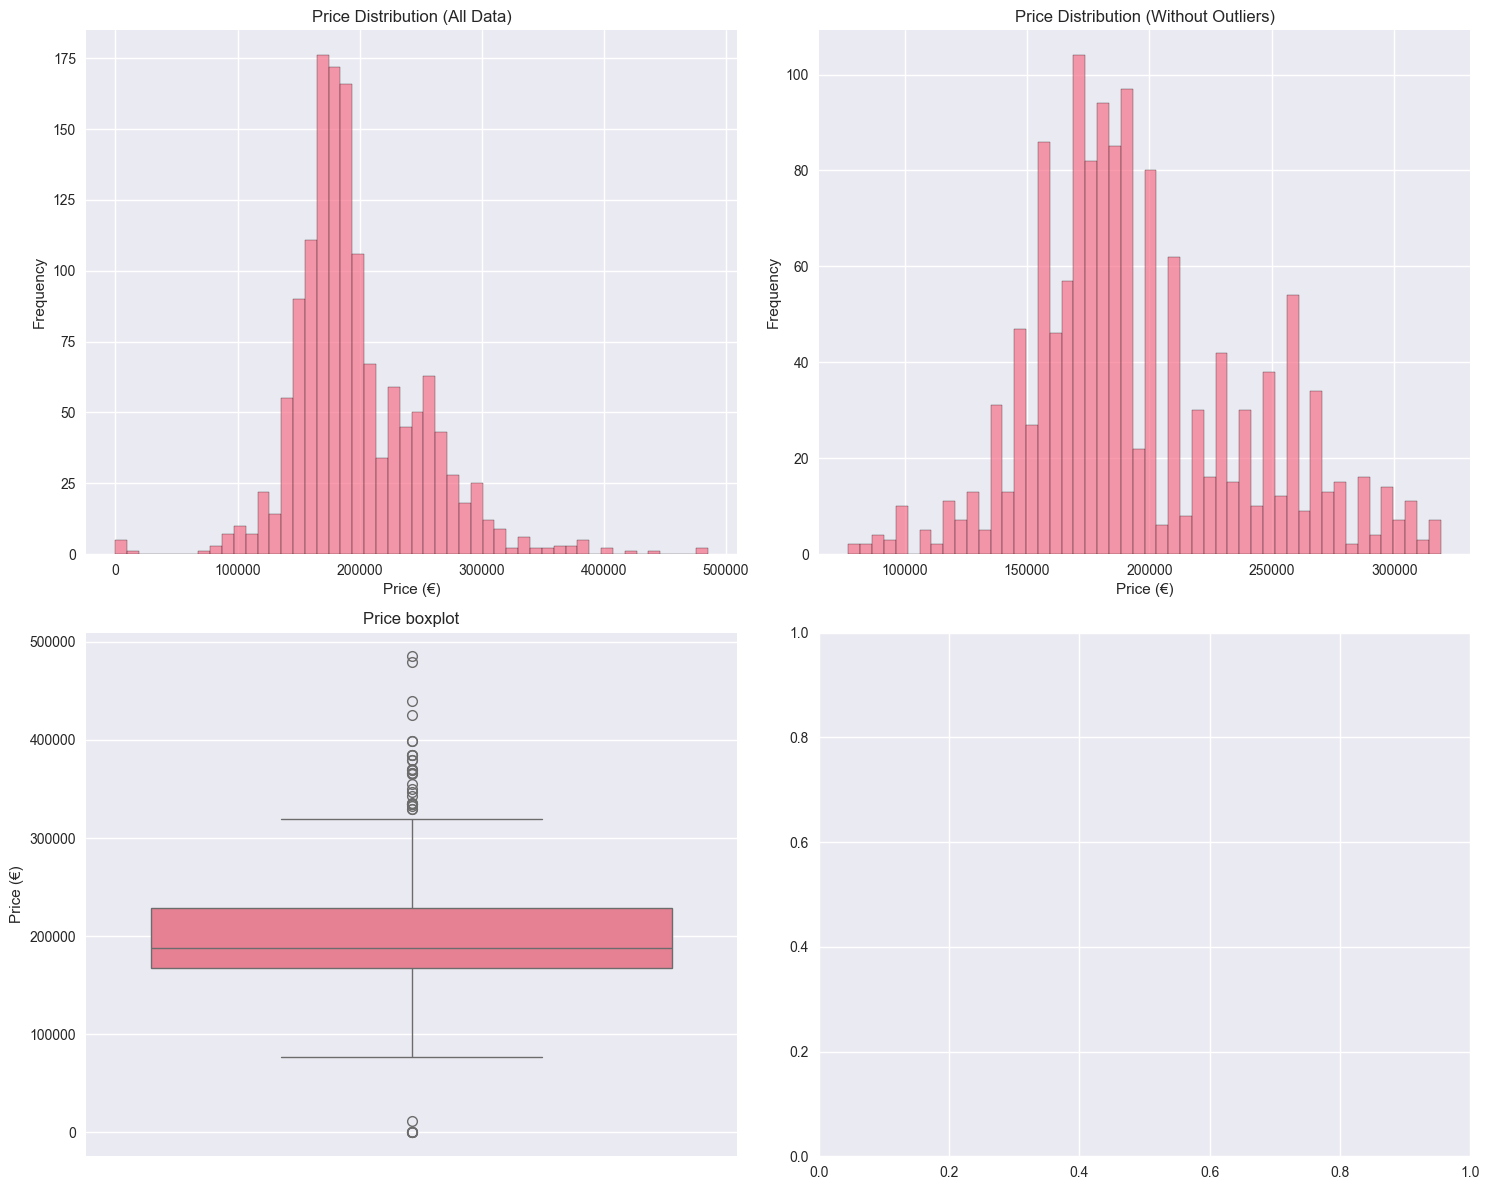

In [17]:
# Price statistics
price_stats = listings_df['current_price'].describe()
print(" Price Statistics:")
print(price_stats)

# Remove extreme outliers for better visualization
Q1 = listings_df['current_price'].quantile(0.25)
Q3 = listings_df['current_price'].quantile(0.75)
IQR = Q3 - Q1
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Create price visualizations
fig, axes = plt.subplots(2, 2, figsize=(15, 12))

# Full price distribution
axes[0,0].hist(listings_df['current_price'], bins=50, alpha=0.7, edgecolor='black')
axes[0,0].set_title('Price Distribution (All Data)')
axes[0,0].set_xlabel('Price (€)')
axes[0,0].set_ylabel('Frequency')

# Price Boxplot
sns.boxplot(data=listings_df, y='current_price', ax=axes[1,0])
axes[1,0].set_title('Price boxplot')
axes[1,0].set_ylabel('Price (€)')

# Price distribution without outliers
price_filtered = listings_df[(listings_df['current_price'] >= lower_bound) & 
                            (listings_df['current_price'] <= upper_bound)]['current_price']
axes[0,1].hist(price_filtered, bins=50, alpha=0.7, edgecolor='black')
axes[0,1].set_title('Price Distribution (Without Outliers)')
axes[0,1].set_xlabel('Price (€)')
axes[0,1].set_ylabel('Frequency')

# # Price by city
# top_cities = listings_df['city'].value_counts().head(10).index
# city_price_data = listings_df[listings_df['city'].isin(top_cities)]
# sns.boxplot(data=city_price_data, x='city', y='current_price', ax=axes[1,1])
# axes[1,1].set_title('Price Distribution by Top 10 Cities')
# axes[1,1].set_xticklabels(axes[1,1].get_xticklabels(), rotation=45)
# axes[1,1].set_ylabel('Price (€)')

plt.tight_layout()
plt.show()


Surface Area Statistics:
count    1428.000000
mean       62.317927
std        17.651291
min         0.000000
25%        53.000000
50%        63.000000
75%        70.000000
max       179.000000
Name: surface_m2, dtype: float64


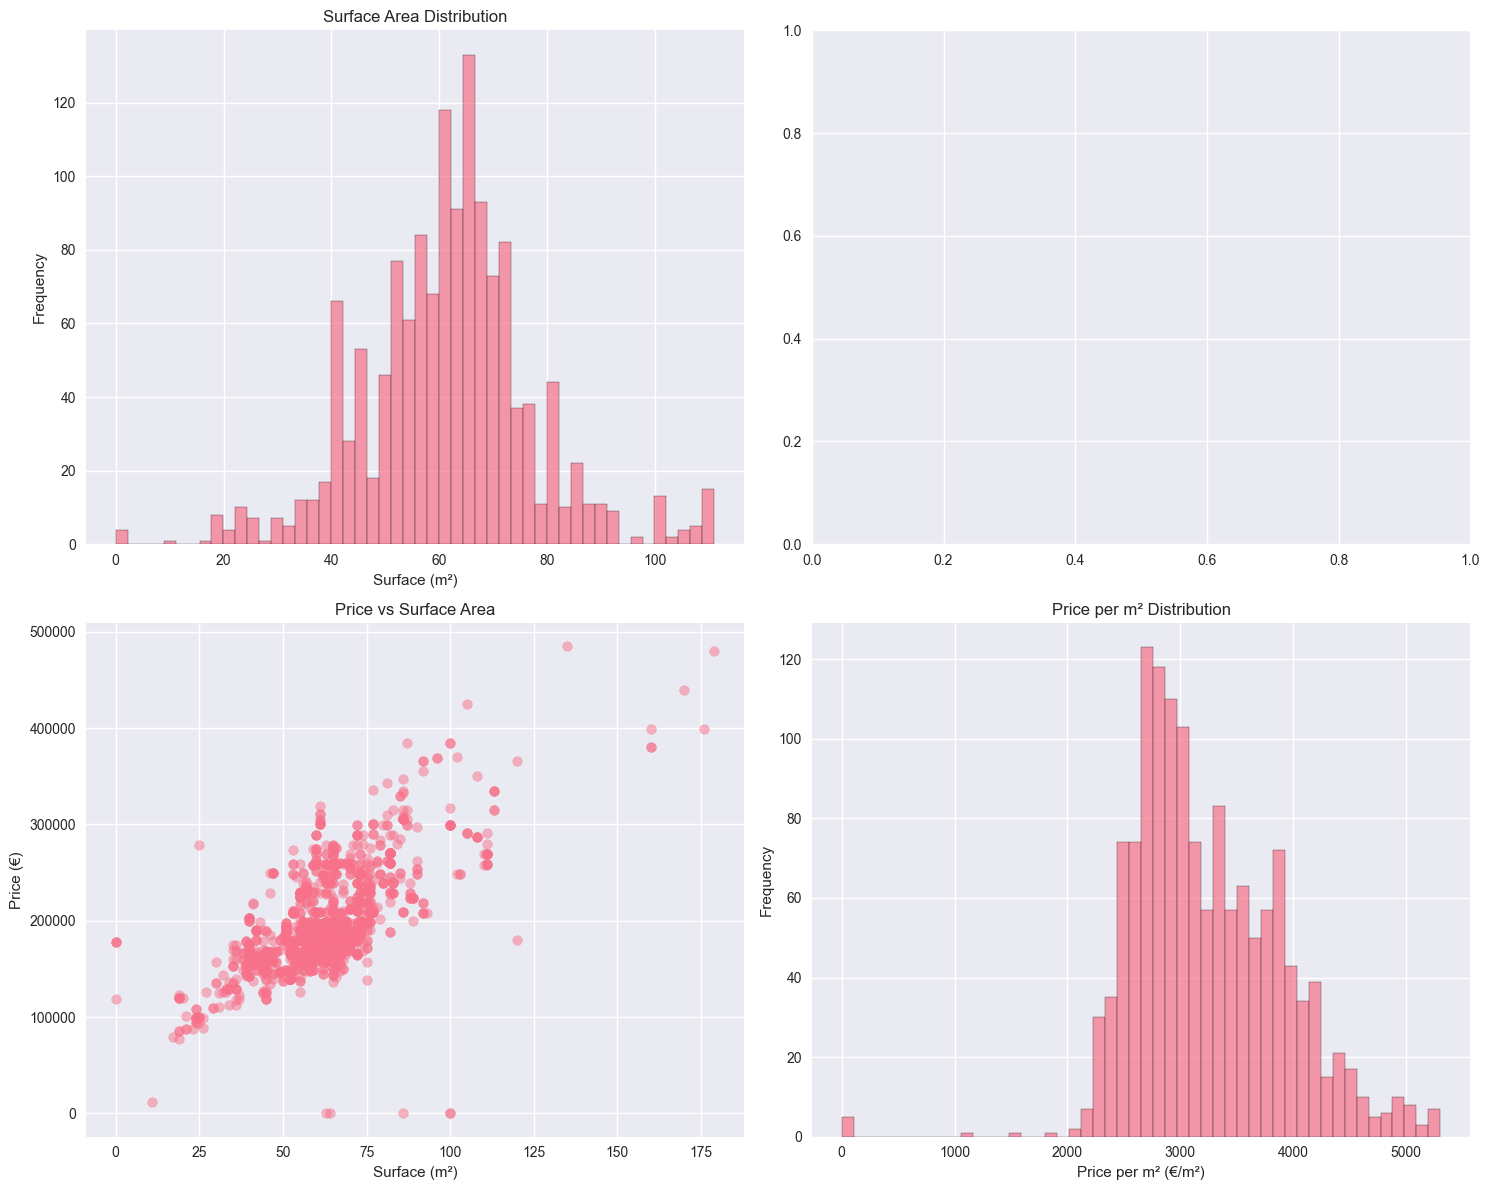

In [20]:
# Surface Area Analysis
surface_stats = listings_df['surface_m2'].dropna().describe()
print("Surface Area Statistics:")
print(surface_stats)

fig, axes = plt.subplots(2, 2, figsize=(15, 12))

# Surface distribution
surface_clean = listings_df['surface_m2'].dropna()
surface_clean = surface_clean[surface_clean <= surface_clean.quantile(0.99)]

axes[0,0].hist(surface_clean, bins=50, alpha=0.7, edgecolor='black')
axes[0,0].set_title('Surface Area Distribution')
axes[0,0].set_xlabel('Surface (m²)')
axes[0,0].set_ylabel('Frequency')

# # Surface by property type
# sns.boxplot(data=listings_df, x='item_type', y='surface_m2', ax=axes[0,1])
# axes[0,1].set_title('Surface by Property Type')
# axes[0,1].set_xticklabels(axes[0,1].get_xticklabels(), rotation=45)
# axes[0,1].set_ylabel('Surface (m²)')

# Price vs Surface scatter
sample_data = listings_df.sample(min(5000, len(listings_df)))  # Sample for performance
axes[1,0].scatter(sample_data['surface_m2'], sample_data['current_price'], alpha=0.5)
axes[1,0].set_title('Price vs Surface Area')
axes[1,0].set_xlabel('Surface (m²)')
axes[1,0].set_ylabel('Price (€)')

# Price per m² distribution
price_per_m2 = listings_df['current_price'] / listings_df['surface_m2']
price_per_m2_clean = price_per_m2.dropna()
price_per_m2_clean = price_per_m2_clean[price_per_m2_clean <= price_per_m2_clean.quantile(0.99)]

axes[1,1].hist(price_per_m2_clean, bins=50, alpha=0.7, edgecolor='black')
axes[1,1].set_title('Price per m² Distribution')
axes[1,1].set_xlabel('Price per m² (€/m²)')
axes[1,1].set_ylabel('Frequency')

plt.tight_layout()
plt.show()

🚪 Room Count Statistics:
count    1425.000000
mean        3.282105
std         0.960086
min         1.000000
25%         3.000000
50%         3.000000
75%         4.000000
max         7.000000
Name: room_count, dtype: float64

📊 Room Count Distribution:


room_count
1.0     28
2.0    263
3.0    544
4.0    487
5.0     81
6.0     16
7.0      6
Name: count, dtype: int64

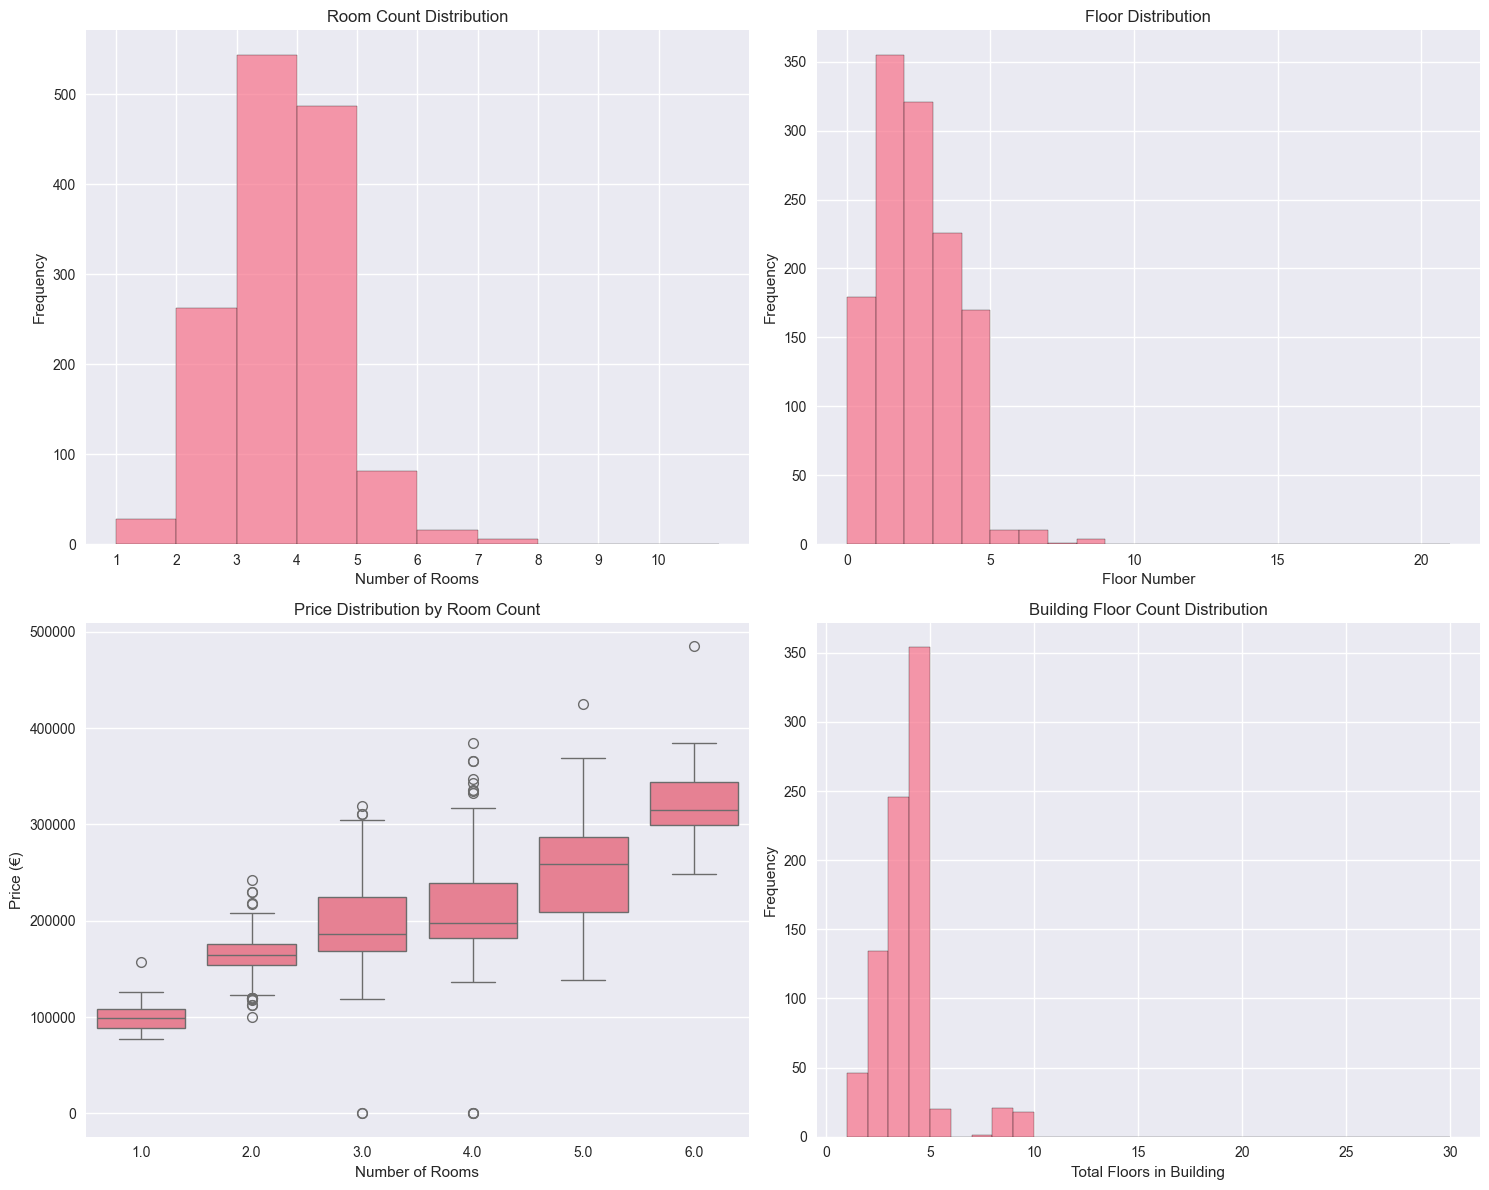

In [23]:
# Room Count and Floor Analysis
# Room count analysis
if 'room_count' in listings_df.columns:
    room_counts = listings_df['room_count'].value_counts().sort_index()
    print(f"🚪 Room Count Statistics:")
    room_stats = listings_df['room_count'].describe()
    print(room_stats)
    
    print(f"\n📊 Room Count Distribution:")
    display(room_counts.head(10))

fig, axes = plt.subplots(2, 2, figsize=(15, 12))

# Room count distribution
if 'room_count' in listings_df.columns:
    room_counts_clean = listings_df['room_count'].dropna()
    room_counts_clean = room_counts_clean[room_counts_clean <= 10]  # Limit to reasonable room counts
    
    axes[0,0].hist(room_counts_clean, bins=range(1, 12), alpha=0.7, edgecolor='black')
    axes[0,0].set_title('Room Count Distribution')
    axes[0,0].set_xlabel('Number of Rooms')
    axes[0,0].set_ylabel('Frequency')
    axes[0,0].set_xticks(range(1, 11))

# Floor analysis
if 'floor' in listings_df.columns:
    floor_clean = listings_df['floor'].dropna()
    floor_clean = floor_clean[(floor_clean >= 0) & (floor_clean <= 20)]  # Reasonable floors
    
    axes[0,1].hist(floor_clean, bins=range(0, 22), alpha=0.7, edgecolor='black')
    axes[0,1].set_title('Floor Distribution')
    axes[0,1].set_xlabel('Floor Number')
    axes[0,1].set_ylabel('Frequency')

# Price by room count
if all(col in listings_df.columns for col in ['room_count', 'current_price']):
    room_price_data = listings_df[(listings_df['room_count'] <= 6) & 
                                (listings_df['room_count'] >= 1)].copy()
    
    sns.boxplot(data=room_price_data, x='room_count', y='current_price', ax=axes[1,0])
    axes[1,0].set_title('Price Distribution by Room Count')
    axes[1,0].set_xlabel('Number of Rooms')
    axes[1,0].set_ylabel('Price (€)')

# Floor count analysis
if 'floor_count' in listings_df.columns:
    floor_count_clean = listings_df['floor_count'].dropna()
    floor_count_clean = floor_count_clean[(floor_count_clean >= 1) & (floor_count_clean <= 30)]
    
    axes[1,1].hist(floor_count_clean, bins=range(1, 31), alpha=0.7, edgecolor='black')
    axes[1,1].set_title('Building Floor Count Distribution')
    axes[1,1].set_xlabel('Total Floors in Building')
    axes[1,1].set_ylabel('Frequency')

plt.tight_layout()
plt.show()

Text Statistics:
   Total descriptions: 1,428
   Non-empty descriptions: 1,428
   Average length: 417 characters
   Average words: 67 words

Length Distribution:
count    1428.00000
mean      417.29902
std       157.69190
min        91.00000
25%       307.00000
50%       413.00000
75%       496.25000
max      2035.00000
Name: description, dtype: float64

Common French Real Estate Terms:


,count,percentage
cuisine,1374.0,96.218487
chambre,1373.0,96.148459
appartement,998.0,69.887955
séjour,988.0,69.187675
gare,865.0,60.574230
parking,825.0,57.773109
cave,809.0,56.652661
proche,706.0,49.439776
salle de bain,669.0,46.848739
balcon,554.0,38.795518


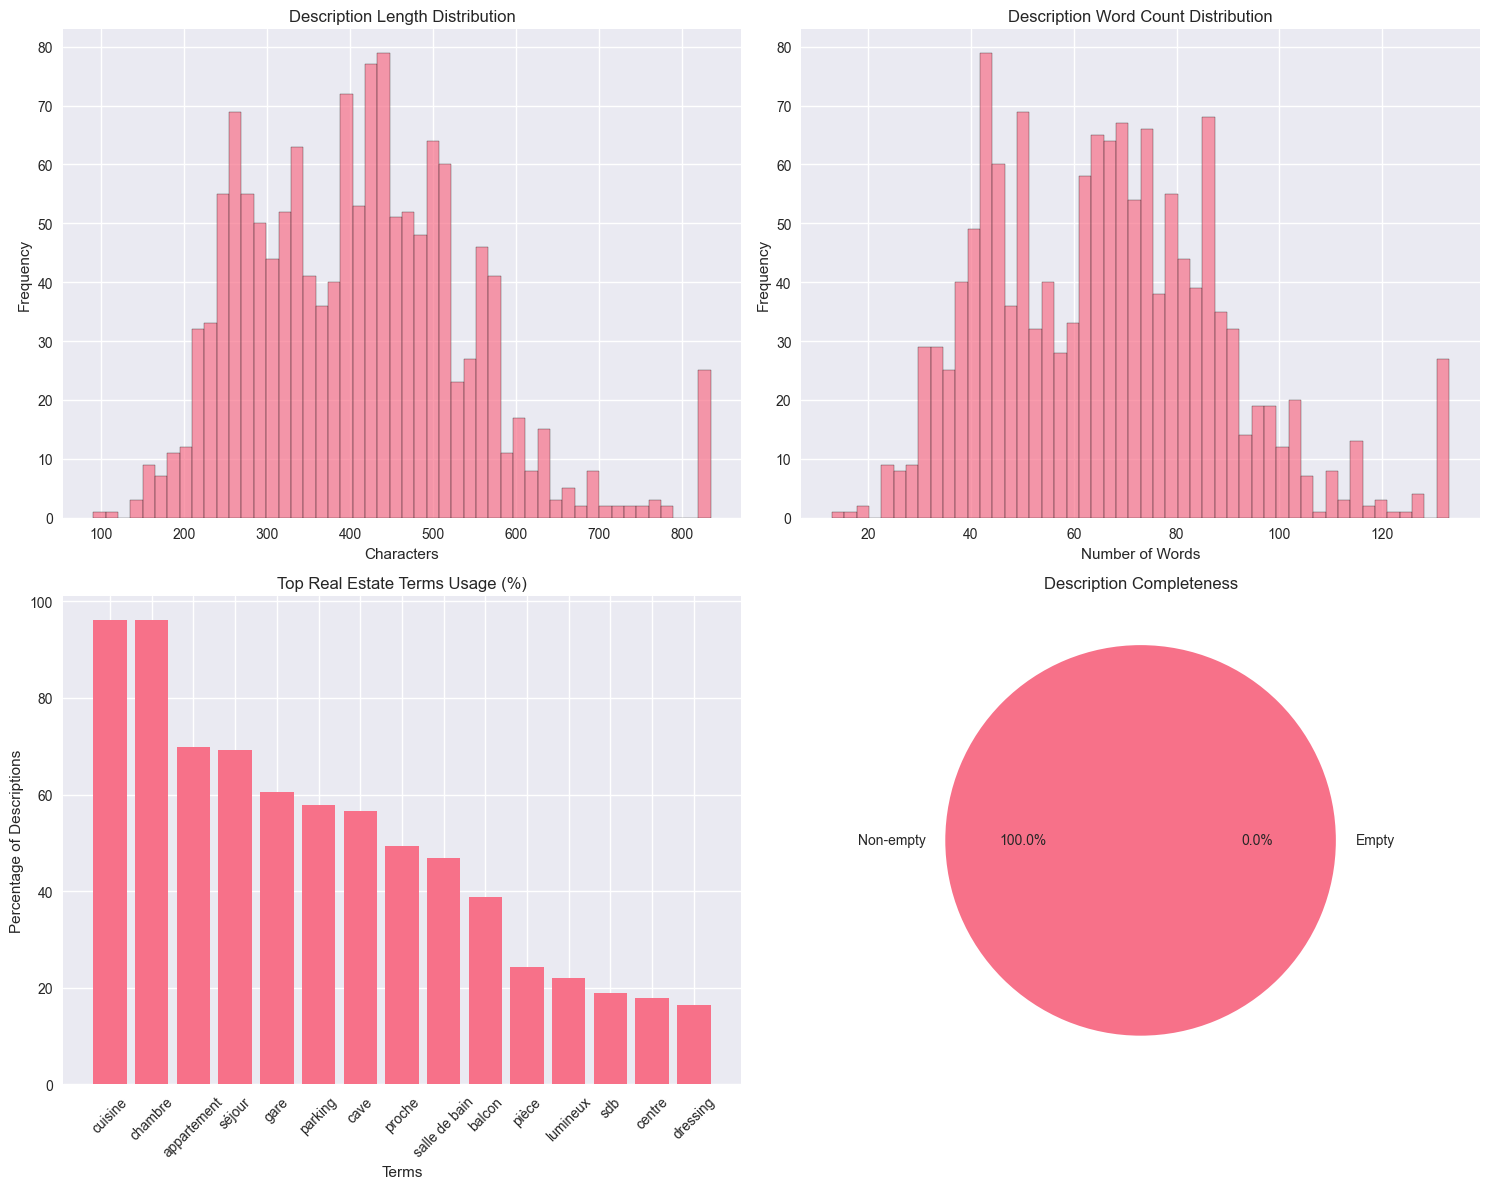

In [21]:
# Description Text Analysis
descriptions = listings_df['description'].dropna()

# Calculate text metrics
desc_lengths = descriptions.str.len()
desc_word_counts = descriptions.str.split().str.len()

print(f"Text Statistics:")
print(f"   Total descriptions: {len(descriptions):,}")
print(f"   Non-empty descriptions: {len(descriptions[descriptions.str.strip() != '']):,}")
print(f"   Average length: {desc_lengths.mean():.0f} characters")
print(f"   Average words: {desc_word_counts.mean():.0f} words")

# Length distribution
print(f"\nLength Distribution:")
print(desc_lengths.describe())

# Common French real estate terms
french_real_estate_terms = [
    'appartement', 'maison', 'studio', 'duplex', 'loft',
    'chambre', 'pièce', 'salon', 'séjour', 'cuisine',
    'salle de bain', 'sdb', 'balcon', 'terrasse', 'jardin',
    'garage', 'parking', 'cave', 'grenier', 'dressing',
    'lumineux', 'calme', 'proche', 'centre', 'gare',
    'métro', 'rénové', 'moderne', 'ancien', 'neuf'
]
    
# Count term occurrences
term_counts = {}
descriptions_lower = descriptions.str.lower()

for term in french_real_estate_terms:
    count = descriptions_lower.str.contains(term, na=False).sum()
    percentage = (count / len(descriptions)) * 100
    term_counts[term] = {'count': count, 'percentage': percentage}

# Create DataFrame for easier analysis
terms_df = pd.DataFrame(term_counts).T
terms_df = terms_df.sort_values('count', ascending=False)

print(f"\nCommon French Real Estate Terms:")
display(terms_df.head(15))

# Text visualizations
fig, axes = plt.subplots(2, 2, figsize=(15, 12))

# Description length distribution
desc_lengths_filtered = desc_lengths[desc_lengths <= desc_lengths.quantile(0.99)]
axes[0,0].hist(desc_lengths_filtered, bins=50, alpha=0.7, edgecolor='black')
axes[0,0].set_title('Description Length Distribution')
axes[0,0].set_xlabel('Characters')
axes[0,0].set_ylabel('Frequency')

# Word count distribution
word_counts_filtered = desc_word_counts[desc_word_counts <= desc_word_counts.quantile(0.99)]
axes[0,1].hist(word_counts_filtered, bins=50, alpha=0.7, edgecolor='black')
axes[0,1].set_title('Description Word Count Distribution')
axes[0,1].set_xlabel('Number of Words')
axes[0,1].set_ylabel('Frequency')
    
# Top terms bar chart
top_terms = terms_df.head(15)
axes[1,0].bar(range(len(top_terms)), top_terms['percentage'])
axes[1,0].set_title('Top Real Estate Terms Usage (%)')
axes[1,0].set_xlabel('Terms')
axes[1,0].set_ylabel('Percentage of Descriptions')
axes[1,0].set_xticks(range(len(top_terms)))
axes[1,0].set_xticklabels(top_terms.index, rotation=45)

# Empty vs non-empty descriptions
empty_descriptions = (descriptions.str.strip() == '').sum()
non_empty_descriptions = len(descriptions) - empty_descriptions

axes[1,1].pie([non_empty_descriptions, empty_descriptions], 
                labels=['Non-empty', 'Empty'], 
                autopct='%1.1f%%')
axes[1,1].set_title('Description Completeness')

plt.tight_layout()
plt.show()


In [ ]:
# Image Files Analysis
# Extract listing IDs from image filenames
image_listing_ids = []

for img_path in image_files:
    filename = img_path.name
    # Extract listing ID from filename pattern: {listing_id}_{number}.jpg
    match = re.match(r'(\d+)_\d+\.jpg', filename)
    if match:
        image_listing_ids.append(int(match.group(1)))



[]
